<a href="https://colab.research.google.com/github/sultankeles/Breast_Cancer_Diagnosis/blob/main/Breast_Cancer_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Upload Dataset**

## 1.1. Download and extract INbreast dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install -q gdown

In [3]:
import zipfile
import gdown
import os

# Google Drive file ID
file_id = "1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4"
zip_output = "INbreast_Release.zip"
extract_to = "/content/INbreast_Extracted"

# Check if file already exists to avoid re-downloading
if not os.path.exists(zip_output):
    gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_output, quiet=False)
else:
    print("ZIP file already exists. Skipping download.")

# Extract zip if not already extracted
if not os.path.exists(extract_to):
    print("Extracting ZIP file...")
    with zipfile.ZipFile(zip_output, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction completed.")
else:
    print("Dataset already extracted. Skipping extraction.")

Downloading...
From (original): https://drive.google.com/uc?id=1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4
From (redirected): https://drive.google.com/uc?id=1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4&confirm=t&uuid=4ca6b17e-91b3-43a3-9c65-daffb7e03900
To: /content/INbreast_Release.zip
100%|██████████| 2.01G/2.01G [00:24<00:00, 81.4MB/s]


Extracting ZIP file...
Extraction completed.


In [4]:
dicom_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs"
jpg_output_dir = "/content/JPGs"

## 1.2 Convert DICOM to JPG

In [5]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 44.8 MB/s eta 0:00:00


In [6]:
import pydicom
import cv2
import numpy as np
import os
from tqdm import tqdm

dicom_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs"
jpg_output_dir = "/content/JPGs"
os.makedirs(jpg_output_dir, exist_ok = True)

def convert_dicom_to_jpg(dicom_path, jpg_path):
    dcm = pydicom.dcmread(dicom_path)
    img = dcm.pixel_array.astype(float)

    # Normalize to 0–255
    img = (np.maximum(img, 0) / img.max()) * 255.0
    img = np.uint8(img)

    # Save
    cv2.imwrite(jpg_path, img)


for filename in tqdm(os.listdir(dicom_dir)):
    if filename.endswith(".dcm"):
        file_id = filename.split("_")[0]
        dicom_path = os.path.join(dicom_dir, filename)
        jpg_path = os.path.join(jpg_output_dir, f"{file_id}.jpg")
        convert_dicom_to_jpg(dicom_path, jpg_path)

100%|██████████| 412/412 [00:54<00:00,  7.60it/s]


## 1.3 Convert ROI XML to JSON

In [7]:
import xml.etree.ElementTree as ET
import os
import json
import re

xml_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllXML"
output_json_path = "/content/annotations.json"
annotations = {}

def parse_point(point_str):
    # Remove parentheses and split into float x, y
    x, y = re.findall(r"[\d.]+", point_str)
    return {"x": int(float(x)), "y": int(float(y))}

for file in os.listdir(xml_dir):
    if not file.endswith(".xml"):
        continue

    xml_path = os.path.join(xml_dir, file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    image_id = file.replace(".xml", "") + ".jpg"
    rois = []

    # Navigate to ROIs
    for roi_group in root.iter("array"):
        for roi in roi_group.findall("dict"):
            name = None
            points = []
            keys = list(roi)
            for i in range(len(keys)):
                if keys[i].tag == "key" and keys[i].text == "Name":
                    name = keys[i+1].text
                if keys[i].tag == "key" and keys[i].text == "Point_px":
                    # Get all point strings inside the <array>
                    px_array = keys[i+1].findall("string")
                    for p in px_array:
                        points.append(parse_point(p.text))
            if name and points:
                rois.append({
                    "label": name,
                    "points": points
                })

    if rois:
        annotations[image_id] = rois

# Save to JSON
with open(output_json_path, "w") as f:
    json.dump(annotations, f, indent=4)

print(f"[INFO] ROI annotations parsed: {len(annotations)} images.")

[INFO] ROI annotations parsed: 343 images.


# **2. Preprocessing & Augmentation**

In [8]:
import os

base_path = "/content/INbreast_Extracted/INbreast Release 1.0"

for root, dirs, files in os.walk(base_path):
    print(f"\n {root}")

    if dirs:
        print(f"   >Subdirectories: {dirs}")

    if files:
        for f in files[:5]:
            print(f"    - {f}")


 /content/INbreast_Extracted/INbreast Release 1.0
   >Subdirectories: ['AllXML', 'AllROI', 'MedicalReports', 'AllDICOMs', 'PectoralMuscle']
    - INbreast.xls
    - inbreast.pdf
    - README.txt
    - INbreast.csv

 /content/INbreast_Extracted/INbreast Release 1.0/AllXML
    - 20586908.xml
    - 20587346.xml
    - 50997107.xml
    - 53586869.xml
    - 20588216.xml

 /content/INbreast_Extracted/INbreast Release 1.0/AllROI
    - 50998177.roi
    - 30011484.roi
    - 22579754.roi
    - 50993426.roi
    - 20587174.roi

 /content/INbreast_Extracted/INbreast Release 1.0/MedicalReports
    - cc9e66c5b31baab8_2009_01.txt
    - 3f0db31711fc9795.txt
    - 1e10aef17c9fe149.txt
    - de5e8d61e501a71b_2010_01.txt
    - f23fa352e7de3dc7.txt

 /content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs
    - 53586442_dda3c6969a34ff8e_MG_R_CC_ANON.dcm
    - 22671003_f571fd4e63c718e3_MG_L_ML_ANON.dcm
    - 53581060_4c341dad22471922_MG_R_CC_ANON.dcm
    - 53581379_b231a8ba4dd4214f_MG_L_ML_ANON.dcm
    -

## 2.1. Data Reading and Review

The INbreast dataset is provided in .csv format and is separated by a semicolon (;).

Therefore, when reading the dataset with pandas, the sep=";" parameter is given.

Otherwise, the columns are separated incorrectly and the data is loaded incorrectly.

In [9]:
import pandas as pd

csv_path = "/content/INbreast_Extracted/INbreast Release 1.0/INbreast.csv"
df = pd.read_csv(csv_path, sep=";")
df["filename"] = df["File Name"].astype(str) + ".jpg"

df_clean = df[["filename", "Laterality", "View", "ACR", "Bi-Rads"]].copy()
df_clean.columns = ["filename", "laterality", "view", "acr_density", "birads_label"]

df_clean.head()

,filename,laterality,view,acr_density,birads_label
0,22678622.jpg,R,CC,4,1
1,22678646.jpg,L,CC,4,3
2,22678670.jpg,R,MLO,4,1
3,22678694.jpg,L,MLO,4,3
4,22614074.jpg,R,CC,2,5


## 2.2. BI-RADS Class Distribution

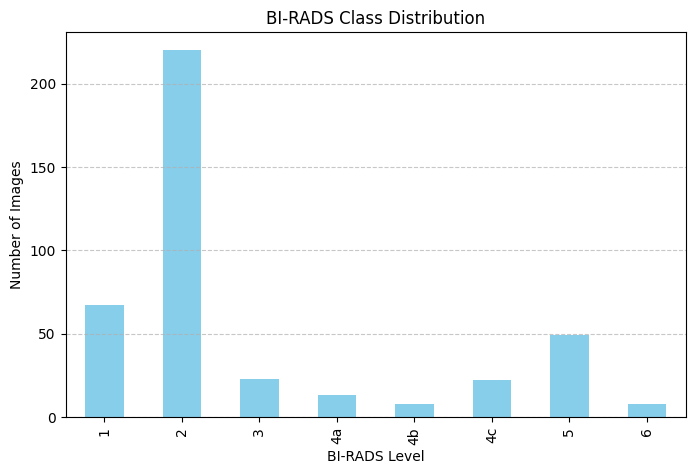

In [11]:
import matplotlib.pyplot as plt

# Count class distribution
birads_counts = df_clean["birads_label"].value_counts().sort_index()

# Visualize
plt.figure(figsize = (8, 5))
birads_counts.plot(kind = "bar", color = "skyblue")
plt.title("BI-RADS Class Distribution")
plt.xlabel("BI-RADS Level")
plt.ylabel("Number of Images")
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show()

### 2.2.1. Sorting Images into Folders Based on BI-RADS Levels

* The .jpg files were copied into folders based on their classes using the df_clean DataFrame.

* Folder names were given as: "BI-RADS-1", "BI-RADS-2", "BI-RADS-3", "BI-RADS-4a", "BI-RADS-4b", "BI-RADS-4ac", "BI-RADS-5", "BI-RADS-6".

In [12]:
import shutil
from tqdm import tqdm

img_source_dir = "/content/JPGs"
output_dir = "/content/BI-RADS_split"
os.makedirs(output_dir, exist_ok=True)

for _, row in tqdm(df_clean.iterrows(), total=len(df_clean), desc = "Organizing images"):
    label = str(row["birads_label"]).strip()
    src = os.path.join(img_source_dir, row["filename"])
    dst_dir = os.path.join(output_dir, f"BIRADS_{label}")
    os.makedirs(dst_dir, exist_ok=True)
    dst = os.path.join(dst_dir, row["filename"])

    if os.path.exists(src):
        shutil.copy(src, dst)

Organizing images: 100%|██████████| 410/410 [00:00<00:00, 1086.65it/s]


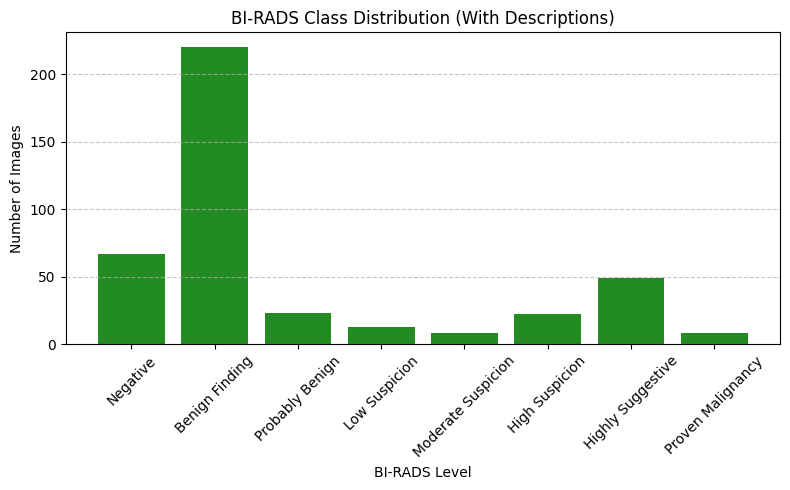

In [13]:
import matplotlib.pyplot as plt

# Label descriptions
label_map = {
    "1": "Negative",
    "2": "Benign Finding",
    "3": "Probably Benign",
    "4a": "Low Suspicion",
    "4b": "Moderate Suspicion",
    "4c": "High Suspicion",
    "5": "Highly Suggestive",
    "6": "Proven Malignancy"
}

def extract_label(folder_name):
    return folder_name.split("_")[-1].lower()

class_counts = {
    class_name: len([f for f in os.listdir(os.path.join(output_dir, class_name)) if f.endswith(".jpg")])
    for class_name in sorted(os.listdir(output_dir)) if class_name.startswith("BIRADS_")
}

sorted_labels = sorted(class_counts.keys(), key=lambda x: extract_label(x))

# Plot the chart
plt.figure(figsize=(8, 5))
plt.bar(
    [label_map.get(extract_label(l), extract_label(l)) for l in sorted_labels],
    [class_counts[l] for l in sorted_labels],
    color = "forestgreen"
)
plt.title("BI-RADS Class Distribution (With Descriptions)")
plt.xlabel("BI-RADS Level")
plt.ylabel("Number of Images")
plt.xticks(rotation = 45)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()

## 2.3. Augmentation

Nested break statements were handled correctly.

The production count was controlled directly using a while loop.

Simplified using print instead of tqdm (can be added again if needed).

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

datagen = ImageDataGenerator(
    rotation_range = 2,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

target_count = 225
base_dir = output_dir  # /content/BI-RADS_split

for class_name in sorted(os.listdir(base_dir)):
    if class_name == "BIRADS_2":
        continue

    class_path = os.path.join(base_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith(".jpg")]
    to_generate = target_count - len(images)

    if to_generate <= 0:
        continue

    generated = 0
    while generated < to_generate:
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size = (224, 224))
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for _ in datagen.flow(x, batch_size = 1,
                                  save_to_dir = class_path,
                                  save_prefix = "aug", save_format = "jpg"):
                generated += 1
                if generated >= to_generate:
                    break
            if generated >= to_generate:
                break

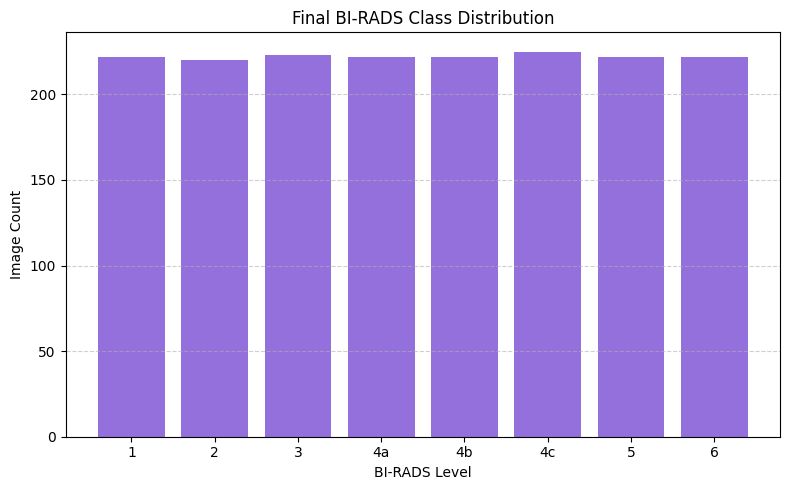

In [15]:
birads_counts_aug = {
    name: len([f for f in os.listdir(os.path.join(base_dir, name)) if f.endswith(".jpg")])
    for name in sorted(os.listdir(base_dir)) if name.startswith("BIRADS_")
}

x_labels = [extract_label(k) for k in birads_counts_aug.keys()]
y_counts = list(birads_counts_aug.values())

plt.figure(figsize=(8, 5))
plt.bar(x_labels, y_counts, color="mediumpurple")
plt.title("Final BI-RADS Class Distribution")
plt.xlabel("BI-RADS Level")
plt.ylabel("Image Count")
plt.grid(axis = "y", linestyle = "--", alpha = 0.6)
plt.tight_layout()
plt.show()

# **3. Dataset Splitting**

In [16]:
import os
import cv2
import numpy as np

original_dir = "/content/BI-RADS_split"

all_classes = sorted(os.listdir(original_dir))

label_map = {}
for idx, label in enumerate(all_classes):
    label_map[label] = idx

img_size = 224

X = []
y = []

for label in all_classes:
    class_path = os.path.join(original_dir, label)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            img = img / 255.0
            X.append(img)
            y.append(label_map[label])


X = np.array(X, dtype=np.float32)
y = np.array(y)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1778, 224, 224, 3)
y shape: (1778,)


## 3.1. Train-Test-Split

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1422, 224, 224, 3)
y_train shape: (1422,)


# **4. Custom CNN Model**

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

## 4.1. Model Architecture

In [19]:
img_size = 224
num_classes = 8

if y_train.ndim != 2:
    y_train = to_categorical(y_train, num_classes = num_classes)
if y_test.ndim != 2:
    y_test = to_categorical(y_test, num_classes = num_classes)

model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_cnn.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
    )

## 4.2. Training

In [20]:
# EarlyStopping
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
)

In [21]:
# ModelCheckpoint
checkpoint = ModelCheckpoint(
    "best_model_cnn.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

In [22]:
import time
start = time.time()

history_cnn = model_cnn.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 50,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.2638 - loss: 2.5073
Epoch 1: val_accuracy improved from -inf to 0.46348, saving model to best_model_cnn.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - accuracy: 0.2647 - loss: 2.4969 - val_accuracy: 0.4635 - val_loss: 1.4397
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4228 - loss: 1.4837
Epoch 2: val_accuracy improved from 0.46348 to 0.54213, saving model to best_model_cnn.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.4233 - loss: 1.4831 - val_accuracy: 0.5421 - val_loss: 1.2636
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5593 - loss: 1.2105
Epoch 3: val_accuracy improved from 0.54213 to 0.58989, saving model to best_model_cnn.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5591 - loss: 1.2109 - val_accuracy: 0.5899 - val_loss: 1.2203
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6180 - loss: 1.0592
Epoch 4: val_accuracy improved fro

## 4.3. Evaluation

In [43]:
from tensorflow.keras.models import load_model

model_cnn.load_weights("best_model_cnn.keras")
loss, acc = model_cnn.evaluate(X_test, y_test, verbose=1)
print(f"\n Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6950 - loss: 1.0994

 Test Accuracy: 0.6910 — Test Loss: 1.1630


## 4.4. Prediction

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [46]:
best_model = load_model("best_model_cnn.keras")

# Prediction
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Ground truth
if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

class_names = ["1", "2", "3", "4a", "4b", "4c", "5", "6"]

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


## 4.5. Classification Report

In [47]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

           1       0.51      0.42      0.46        45
           2       0.62      0.64      0.63        44
           3       0.57      0.73      0.64        45
          4a       0.93      0.95      0.94        44
          4b       0.65      0.68      0.67        44
          4c       0.86      0.84      0.85        45
           5       0.67      0.64      0.66        45
           6       0.71      0.61      0.66        44

    accuracy                           0.69       356
   macro avg       0.69      0.69      0.69       356
weighted avg       0.69      0.69      0.69       356



## 4.6. Confusion Matrix

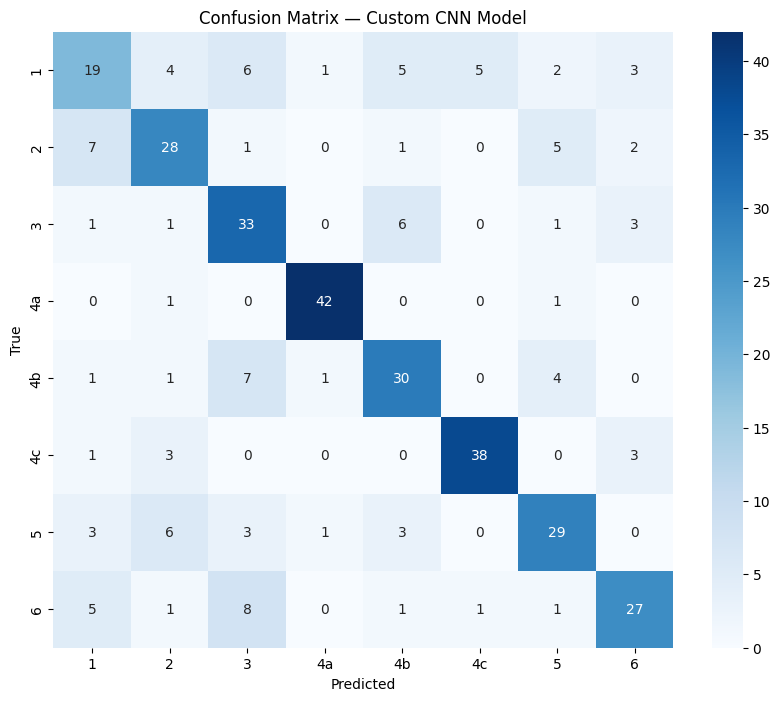

In [48]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion Matrix — Custom CNN Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 4.7. Accuracy & Loss Graphs

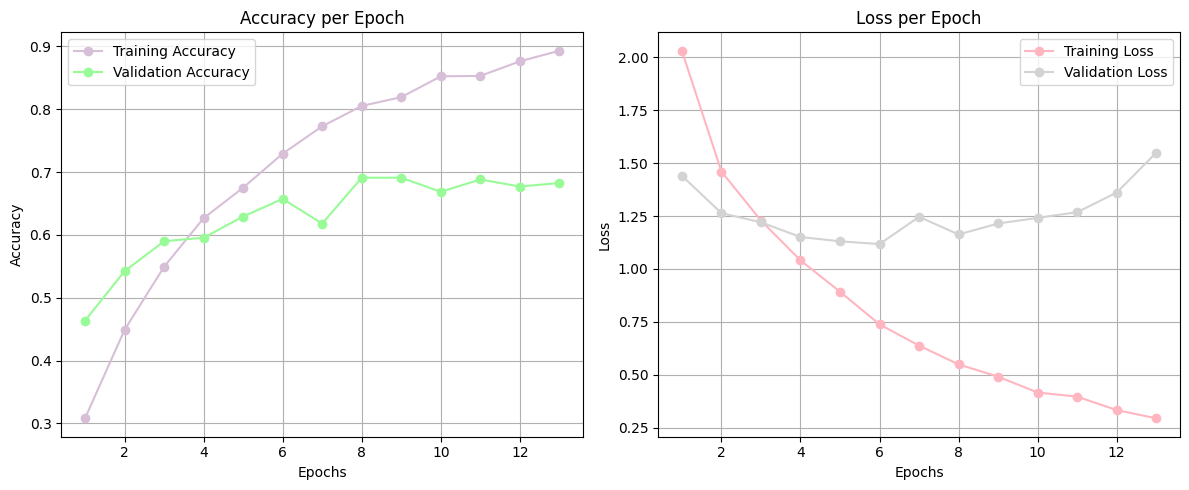

In [49]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker = 'o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **5. DenseNet121**

In [50]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 5.1. Model Architecture

In [51]:
input_shape = (224, 224, 3)
num_classes = 8

base_model = DenseNet121(weights = 'imagenet', include_top = False, input_tensor = Input(shape = input_shape))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation = 'softmax')(x)

# Final model
model_densenet = Model(inputs = base_model.input, outputs = output)

# Compile
model_densenet.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model_densenet.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 13,461,192 (51.35 MB)

 Trainable params: 6,423,688 (24.50 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

## 5.2. Training

In [52]:
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
    )

checkpoint = ModelCheckpoint(
    "best_model_densenet.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
    )

In [53]:
import time
start = time.time()

history_densenet = model_densenet.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.4414 - loss: 2.2715
Epoch 1: val_accuracy improved from -inf to 0.85393, saving model to best_model_densenet.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 65s 864ms/step - accuracy: 0.4450 - loss: 2.2527 - val_accuracy: 0.8539 - val_loss: 0.5289
Epoch 2/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7900 - loss: 0.6178
Epoch 2: val_accuracy improved from 0.85393 to 0.87640, saving model to best_model_densenet.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.7911 - loss: 0.6158 - val_accuracy: 0.8764 - val_loss: 0.4362
Epoch 3/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8504 - loss: 0.4783
Epoch 3: val_accuracy did not improve from 0.87640
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.8503 - loss: 0.4785 - val_accuracy: 0.8680 - val_loss: 0.4093
Epoch 4/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8623 - loss: 0.4433
Epoch 4: val_accuracy improved from 0.87640 to 0.88764, savi

## 5.3. Evaluation

In [54]:
from tensorflow.keras.models import load_model

model = load_model("best_model_densenet.keras")

loss, acc = model.evaluate(X_test, y_test, verbose = 1)
print(f"\nTest Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 568ms/step - accuracy: 0.8922 - loss: 0.4032

Test Accuracy: 0.8989 — Test Loss: 0.3918


## 5.4. Prediction

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [56]:
best_model = load_model("best_model_densenet.keras")

y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

class_names = ["1", "2", "3", "4a", "4b", "4c", "5", "6"]

12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step


## 5.5. Classification Report

In [57]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

           1       0.85      0.76      0.80        45
           2       0.61      0.86      0.72        44
           3       0.96      0.96      0.96        45
          4a       0.98      0.95      0.97        44
          4b       0.98      0.98      0.98        44
          4c       1.00      0.89      0.94        45
           5       0.97      0.82      0.89        45
           6       0.98      0.98      0.98        44

    accuracy                           0.90       356
   macro avg       0.92      0.90      0.90       356
weighted avg       0.92      0.90      0.90       356



## 5.6. Confusion Matrix

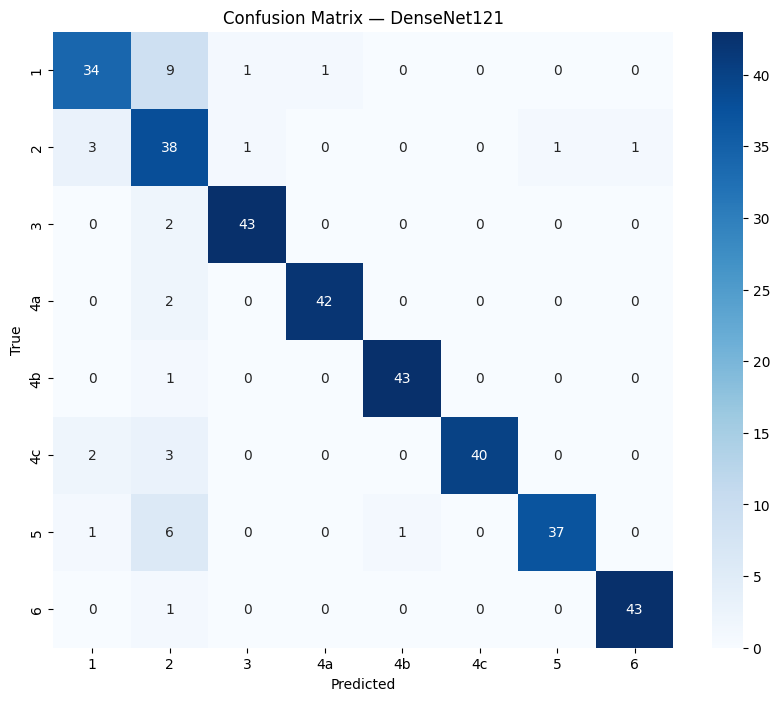

In [58]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion Matrix — DenseNet121")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 5.7. Accuracy & Loss Graphs

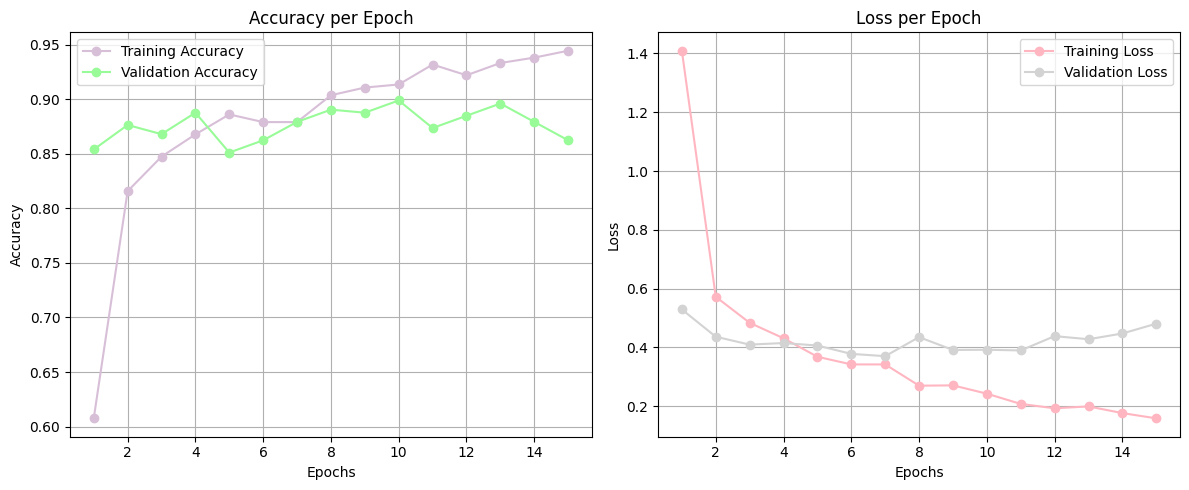

In [59]:
import matplotlib.pyplot as plt

acc = history_densenet.history['accuracy']
val_acc = history_densenet.history['val_accuracy']
loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker='o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **7. VGG16**

## 7.1. Feature Extraction

In [60]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

input_shape = (224, 224, 3)
num_classes = 8

base_model = VGG16(weights = 'imagenet', include_top = False, input_tensor = Input(shape = input_shape))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation = 'softmax')(x)

# Final model
model_vgg16 = Model(inputs = base_model.input, outputs = output)

# Compile
model_vgg16.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model_vgg16.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,927,112 (68.39 MB)

 Trainable params: 3,212,424 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 7.2. Training

In [61]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

checkpoint = ModelCheckpoint(
    "best_model_vgg16.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

In [62]:
import time
start = time.time()

history_vgg16 = model_vgg16.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.2777 - loss: 2.0434
Epoch 1: val_accuracy improved from -inf to 0.70787, saving model to best_model_vgg16.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 32s 444ms/step - accuracy: 0.2806 - loss: 2.0360 - val_accuracy: 0.7079 - val_loss: 1.1392
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6566 - loss: 1.1682
Epoch 2: val_accuracy improved from 0.70787 to 0.82303, saving model to best_model_vgg16.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.6569 - loss: 1.1672 - val_accuracy: 0.8230 - val_loss: 0.8237
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7536 - loss: 0.9112
Epoch 3: val_accuracy improved from 0.82303 to 0.85112, saving model to best_model_vgg16.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.7538 - loss: 0.9104 - val_accuracy: 0.8511 - val_loss: 0.6718
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7948 - loss: 0.7589
Epoch 4: val_accur

## 7.3. Evaluation

In [63]:
from tensorflow.keras.models import load_model

best_model_vgg16 = load_model("best_model_vgg16.keras")
loss, acc = model_vgg16.evaluate(X_test, y_test, verbose=1)
print(f"\n Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.8874 - loss: 0.4214

 Test Accuracy: 0.8904 — Test Loss: 0.4215


## 7.4. Prediction

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [65]:
best_model = load_model("best_model_vgg16.keras")

y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

class_names = ["1", "2", "3", "4a", "4b", "4c", "5", "6"]

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step


## 7.5. Classification Report

In [66]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

           1       0.91      0.71      0.80        45
           2       0.57      0.89      0.70        44
           3       1.00      0.98      0.99        45
          4a       0.95      0.95      0.95        44
          4b       0.98      0.98      0.98        44
          4c       0.98      0.89      0.93        45
           5       0.94      0.76      0.84        45
           6       0.98      0.98      0.98        44

    accuracy                           0.89       356
   macro avg       0.91      0.89      0.90       356
weighted avg       0.92      0.89      0.90       356



## 7.6. Confusion Matrix

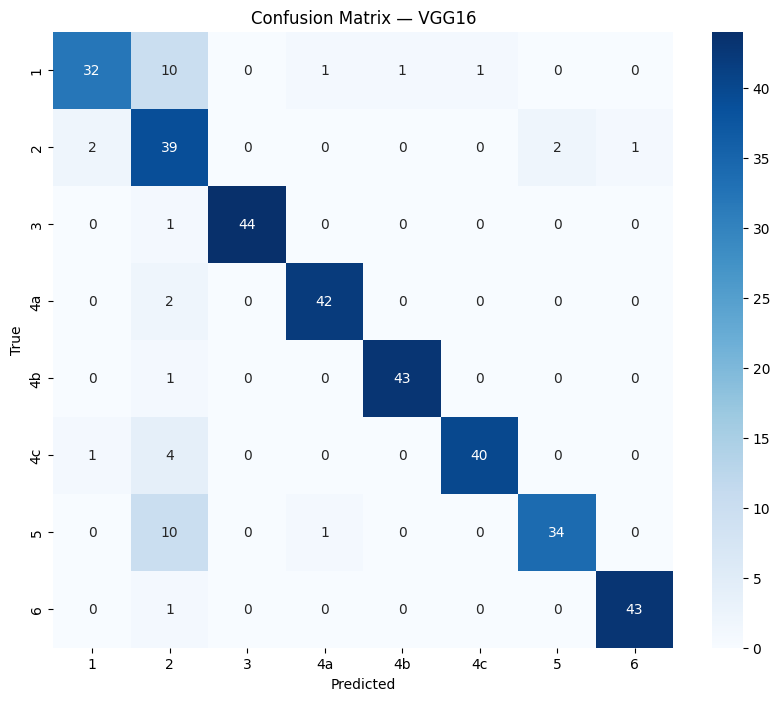

In [67]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion Matrix — VGG16")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 7.7. Accuracy & Loss Graphs

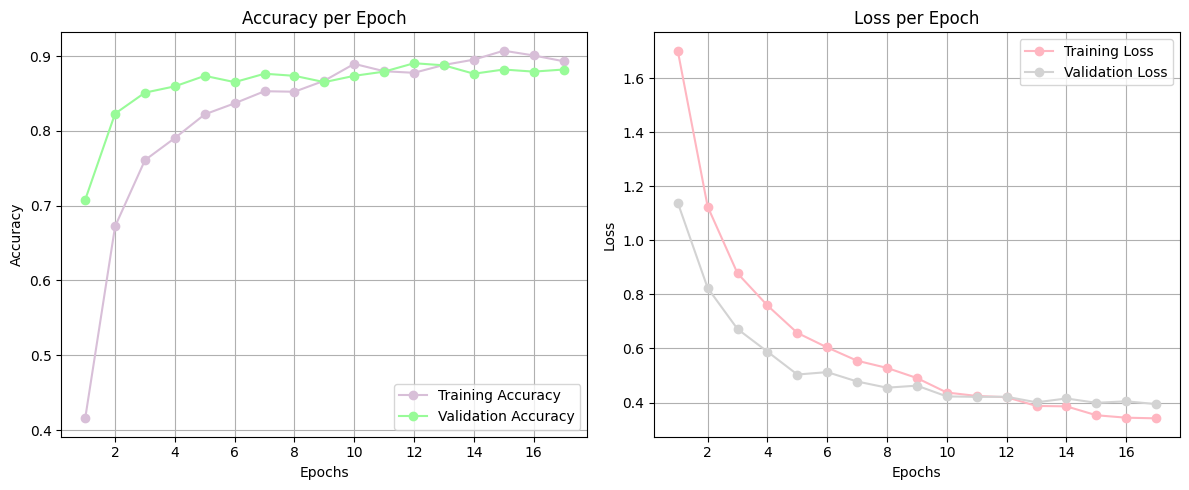

In [68]:
import matplotlib.pyplot as plt

acc = history_vgg16.history['accuracy']
val_acc = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker='o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **8. EfficientNetB0**

In [121]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## 8.1. Feature Extraction

In [122]:
input_shape = (224, 224, 3)
num_classes = 8

base_model = EfficientNetB0(weights = 'imagenet', include_top = False, input_tensor = Input(shape = input_shape))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation = 'softmax')(x)

# Final model
model_efficientnet = Model(inputs = base_model.input, outputs = output)

In [123]:
# Compile
model_efficientnet.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model_efficientnet.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,571 (16.08 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## 8.2. Training

In [124]:
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
    )
checkpoint = ModelCheckpoint(
    "best_model_efficientnet.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
    )

In [125]:
import time
start = time.time()

history_efficient = model_efficientnet.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.1206 - loss: 2.1035
Epoch 1: val_accuracy improved from -inf to 0.12640, saving model to best_model_efficientnet.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 472ms/step - accuracy: 0.1205 - loss: 2.1036 - val_accuracy: 0.1264 - val_loss: 2.0808
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1215 - loss: 2.0967
Epoch 2: val_accuracy did not improve from 0.12640
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.1215 - loss: 2.0967 - val_accuracy: 0.1236 - val_loss: 2.0800
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1425 - loss: 2.0811
Epoch 3: val_accuracy did not improve from 0.12640
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.1424 - loss: 2.0812 - val_accuracy: 0.1264 - val_loss: 2.0809
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1463 - loss: 2.0816
Epoch 4: val_accuracy did not improve from 0.12640
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0

## 8.3. Evaluation

In [126]:
from tensorflow.keras.models import load_model

best_model_efficientnet = load_model("best_model_efficientnet.keras")
loss, acc = model_efficientnet.evaluate(X_test, y_test, verbose=1)
print(f"\n Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1164 - loss: 2.0840

 Test Accuracy: 0.1264 — Test Loss: 2.0808


## 8.4. Prediction

In [127]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [128]:
best_model = load_model("best_model_efficientnet.keras")

y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

class_names = ["1", "2", "3", "4a", "4b", "4c", "5", "6"]

12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 481ms/step


## 8.5. Classification Report

In [129]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        45
           2       0.00      0.00      0.00        44
           3       0.00      0.00      0.00        45
          4a       0.00      0.00      0.00        44
          4b       0.00      0.00      0.00        44
          4c       0.00      0.00      0.00        45
           5       0.13      1.00      0.22        45
           6       0.00      0.00      0.00        44

    accuracy                           0.13       356
   macro avg       0.02      0.12      0.03       356
weighted avg       0.02      0.13      0.03       356



## 8.6. Confusion Matrix

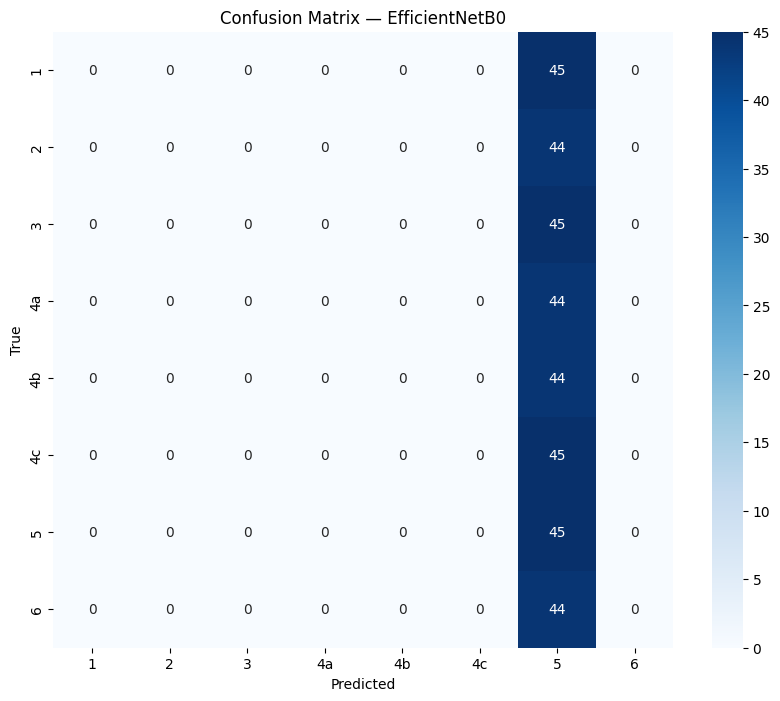

In [130]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — EfficientNetB0')
plt.show()

## 8.7. Accuracy & Loss Graphs

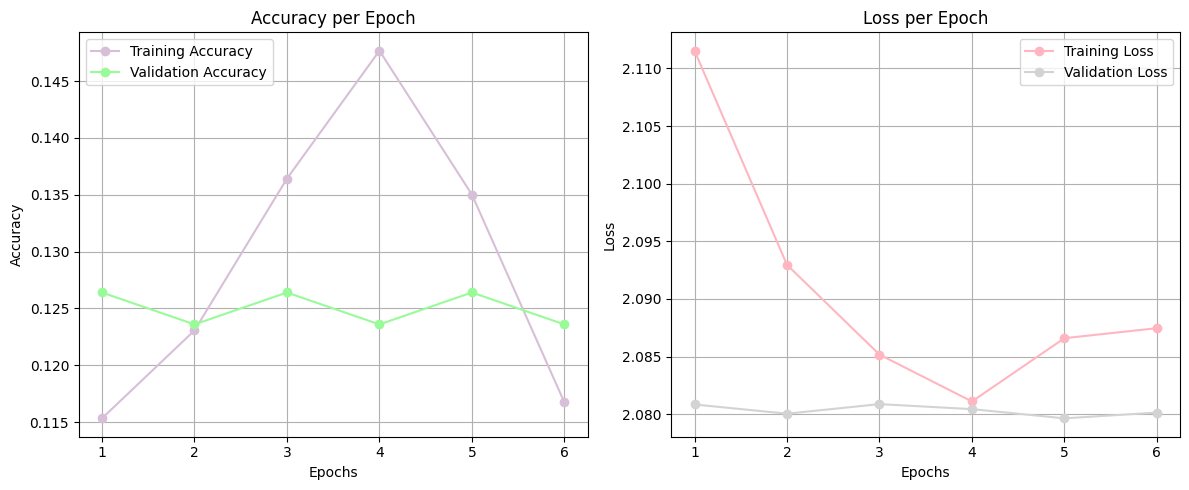

In [131]:
import matplotlib.pyplot as plt

acc = history_efficient.history['accuracy']
val_acc = history_efficient.history['val_accuracy']
loss = history_efficient.history['loss']
val_loss = history_efficient.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker='o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 8.8. Fine-Tuning

In [132]:
# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

In [133]:
from tensorflow.keras.optimizers import Adam

model_efficientnet.compile(
    optimizer = Adam(learning_rate = 1e-5),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [134]:
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
    )
checkpoint = ModelCheckpoint(
    "best_model_efficientnet_finetuned.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
    )

In [135]:
# Training
fine_tune_start = time.time()

history_efficient_finetuned = model_efficientnet.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 20,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

fine_tune_end = time.time()
ft_minutes = (fine_tune_end - fine_tune_start) // 60
ft_seconds = (fine_tune_end - fine_tune_start) % 60

print(f"Fine-Tuning Time: {int(ft_minutes)} minutes {int(ft_seconds)} seconds")

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.1146 - loss: 2.1379
Epoch 1: val_accuracy improved from -inf to 0.12640, saving model to best_model_efficientnet_finetuned.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 49s 536ms/step - accuracy: 0.1147 - loss: 2.1374 - val_accuracy: 0.1264 - val_loss: 2.0812
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1251 - loss: 2.1158
Epoch 2: val_accuracy did not improve from 0.12640
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.1252 - loss: 2.1156 - val_accuracy: 0.1264 - val_loss: 2.0831
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1532 - loss: 2.0928
Epoch 3: val_accuracy did not improve from 0.12640
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.1530 - loss: 2.0928 - val_accuracy: 0.1236 - val_loss: 2.0843
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1258 - loss: 2.1003
Epoch 4: val_accuracy did not improve from 0.12640
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accur

### 9.7.1. Fine-Tuning vs. Initial Training

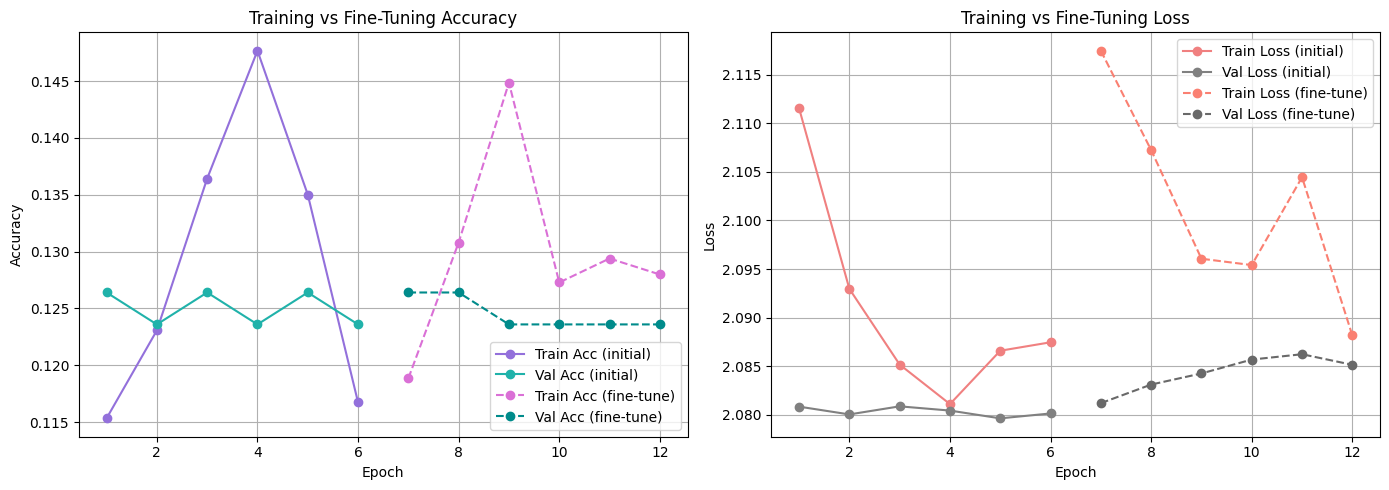

In [136]:
import matplotlib.pyplot as plt

# Extract history
acc_initial = history_efficient.history['accuracy']
val_acc_initial = history_efficient.history['val_accuracy']
loss_initial = history_efficient.history['loss']
val_loss_initial = history_efficient.history['val_loss']

acc_ft = history_efficient_finetuned.history['accuracy']
val_acc_ft = history_efficient_finetuned.history['val_accuracy']
loss_ft = history_efficient_finetuned.history['loss']
val_loss_ft = history_efficient_finetuned.history['val_loss']

# Epochs
epochs_initial = range(1, len(acc_initial) + 1)
epochs_ft = range(len(acc_initial) + 1, len(acc_initial) + len(acc_ft) + 1)

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_initial, acc_initial, 'o-', label='Train Acc (initial)', color='mediumpurple')
plt.plot(epochs_initial, val_acc_initial, 'o-', label='Val Acc (initial)', color='lightseagreen')
plt.plot(epochs_ft, acc_ft, 'o--', label='Train Acc (fine-tune)', color='orchid')
plt.plot(epochs_ft, val_acc_ft, 'o--', label='Val Acc (fine-tune)', color='darkcyan')
plt.title('Training vs Fine-Tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_initial, loss_initial, 'o-', label='Train Loss (initial)', color='lightcoral')
plt.plot(epochs_initial, val_loss_initial, 'o-', label='Val Loss (initial)', color='gray')
plt.plot(epochs_ft, loss_ft, 'o--', label='Train Loss (fine-tune)', color='salmon')
plt.plot(epochs_ft, val_loss_ft, 'o--', label='Val Loss (fine-tune)', color='dimgray')
plt.title('Training vs Fine-Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

According to the graphs, the fine-tuning process has started, but the overall performance of the model is still quite low.

Validation Accuracy has remained constant (~12–13%), meaning the model has not improved on the validation set. Training Accuracy (fine-tune) has increased, but this creates a risk of overfitting because validation has not changed at all. Validation Loss is on an increasing trend, and the model generalizes poorly on the validation set.

# **9. ResNet50**

In [80]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 9.1. Feature Extraction

In [81]:
input_shape = (224, 224, 3)
num_classes = 8

base_model = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = input_shape))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation = 'softmax')(x)

model_resnet50 = Model(inputs = base_model.input, outputs = output)

# Compile
model_resnet50.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model_resnet50.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,016 (90.98 MB)

 Trainable params: 263,304 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 9.2. Training

In [82]:
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
    )
checkpoint = ModelCheckpoint(
    "best_model_resnet50.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
    )

In [83]:
import time
start = time.time()

history_resnet50 = model_resnet50.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    verbose = 1
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.1343 - loss: 2.7259
Epoch 1: val_accuracy improved from -inf to 0.14607, saving model to best_model_resnet50.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 381ms/step - accuracy: 0.1342 - loss: 2.7220 - val_accuracy: 0.1461 - val_loss: 2.0760
Epoch 2/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1175 - loss: 2.3260
Epoch 2: val_accuracy improved from 0.14607 to 0.21348, saving model to best_model_resnet50.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.1178 - loss: 2.3236 - val_accuracy: 0.2135 - val_loss: 2.0674
Epoch 3/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.1245 - loss: 2.1783
Epoch 3: val_accuracy did not improve from 0.21348
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.1250 - loss: 2.1775 - val_accuracy: 0.1320 - val_loss: 2.0631
Epoch 4/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.0979 - loss: 2.1495
Epoch 4: val_accuracy did not improve from 0.21348
45/45 ━━

## 9.3. Evaluation

In [84]:
from tensorflow.keras.models import load_model

best_model_resnet50 = load_model("best_model_resnet50.keras")
loss, acc = model_resnet50.evaluate(X_test, y_test, verbose=1)
print(f"\n Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5759 - loss: 1.9390

 Test Accuracy: 0.6152 — Test Loss: 1.9339


## 9.4. Prediction

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [86]:
best_model = load_model("best_model_resnet50.keras")

y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


if y_test.ndim > 1 and y_test.shape[1] > 1:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

class_names = ["1", "2", "3", "4a", "4b", "4c", "5", "6"]

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 403ms/step


## 9.5. Classification Report

In [87]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:

              precision    recall  f1-score   support

           1       0.63      0.27      0.38        45
           2       0.60      0.41      0.49        44
           3       0.44      0.73      0.55        45
          4a       0.52      0.98      0.68        44
          4b       0.71      0.50      0.59        44
          4c       0.93      0.62      0.75        45
           5       0.72      0.69      0.70        45
           6       0.71      0.73      0.72        44

    accuracy                           0.62       356
   macro avg       0.66      0.62      0.61       356
weighted avg       0.66      0.62      0.61       356



## 9.6. Confusion Matrix

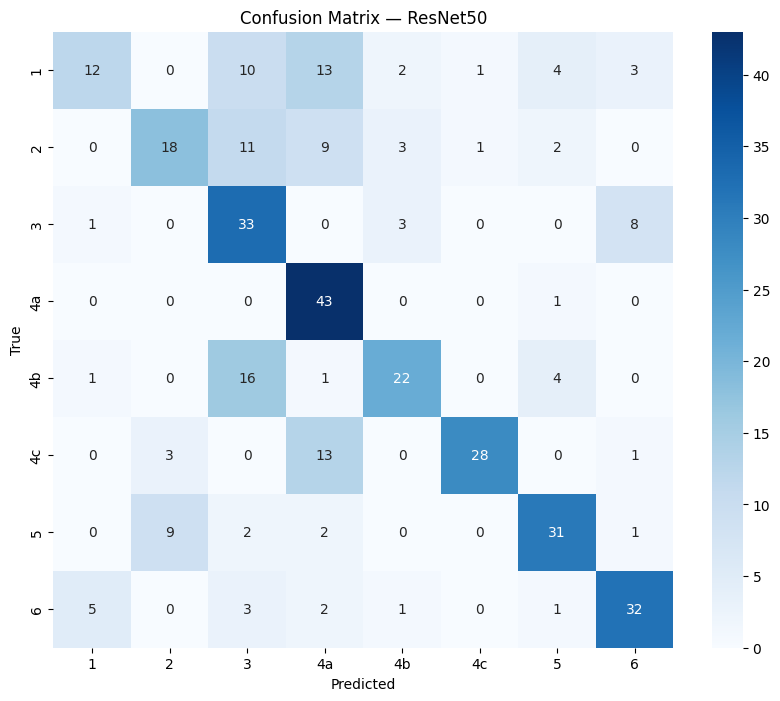

In [88]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — ResNet50')
plt.show()

## 9.7. Accuracy & Loss Graphs

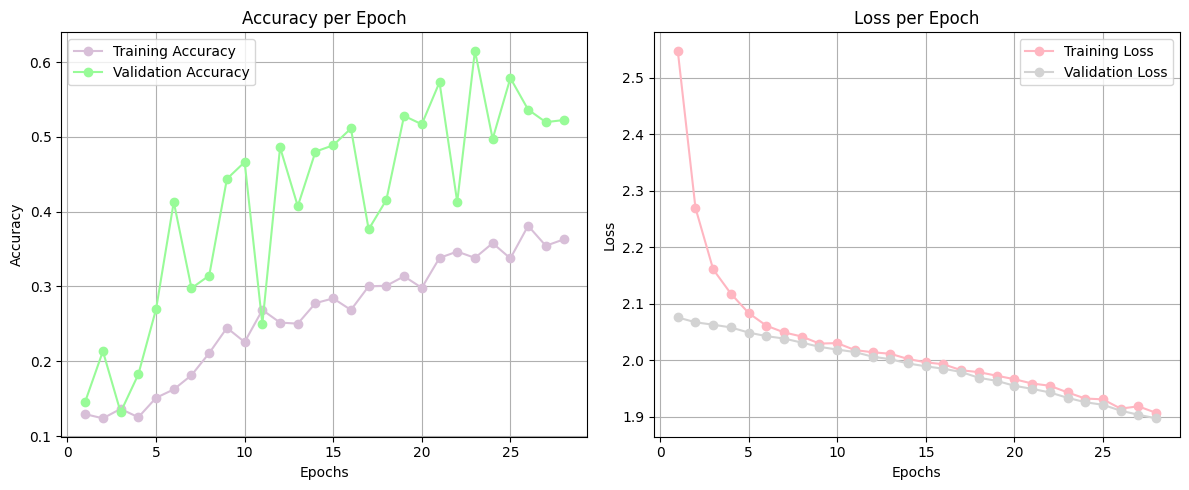

In [89]:
import matplotlib.pyplot as plt

acc = history_resnet50.history['accuracy']
val_acc = history_resnet50.history['val_accuracy']
loss = history_resnet50.history['loss']
val_loss = history_resnet50.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker='o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **10. Model Comparison**

In [137]:
import pandas as pd

model_paths = {
    'CNN': '/content/best_model_cnn.keras',
    'VGG16': '/content/best_model_vgg16.keras',
    'EfficientNet': '/content/best_model_efficientnet.keras',
    'EfficientNet_FineTuned': '/content/best_model_efficientnet_finetuned.keras',
    'ResNet50': '/content/best_model_resnet50.keras',
    'DenseNet121': '/content/best_model_densenet.keras'
}

model_histories = {
    'CNN': history_cnn,
    'VGG16': history_vgg16,
    'EfficientNet': history_efficient,
    'ResNet50': history_resnet50,
    'EfficientNet_FineTuned': history_efficient_finetuned,
    'DenseNet121': history_densenet
}

training_times = {
    'CNN': '0 minutes 45 seconds',
    'VGG16': '2 minutes 57 seconds',
    'EfficientNet': '0 minutes 52 seconds',
    'EfficientNet_FineTuned': '1 minutes 2 seconds',
    'ResNet50': '2 minutes 42 seconds',
    'DenseNet121': '2 minutes 9 seconds'
}

In [139]:
model_comparisons = []

for model_name, history in model_histories.items():
    hist = history.history

    model_comparisons.append({
        'Model': model_name,
        'Accuracy': round(hist.get('accuracy', [None])[-1], 3),
        'Loss': round(hist.get('loss', [None])[-1], 3),
        'Validation Accuracy': round(hist.get('val_accuracy', [None])[-1], 3),
        'Validation Loss': round(hist.get('val_loss', [None])[-1], 3),
        'Training Time': training_times.get(model_name, 'N/A')
    })

df_comparison = pd.DataFrame(model_comparisons)
display(df_comparison)

,Model,Accuracy,Loss,Validation Accuracy,Validation Loss,Training Time
0,CNN,0.893,0.295,0.683,1.549,0 minutes 45 seconds
1,VGG16,0.893,0.342,0.882,0.394,2 minutes 57 seconds
2,EfficientNet,0.117,2.087,0.124,2.080,0 minutes 52 seconds
3,ResNet50,0.363,1.907,0.522,1.898,2 minutes 42 seconds
4,EfficientNet_FineTuned,0.128,2.088,0.124,2.085,1 minutes 2 seconds
5,DenseNet121,0.944,0.158,0.862,0.481,2 minutes 9 seconds


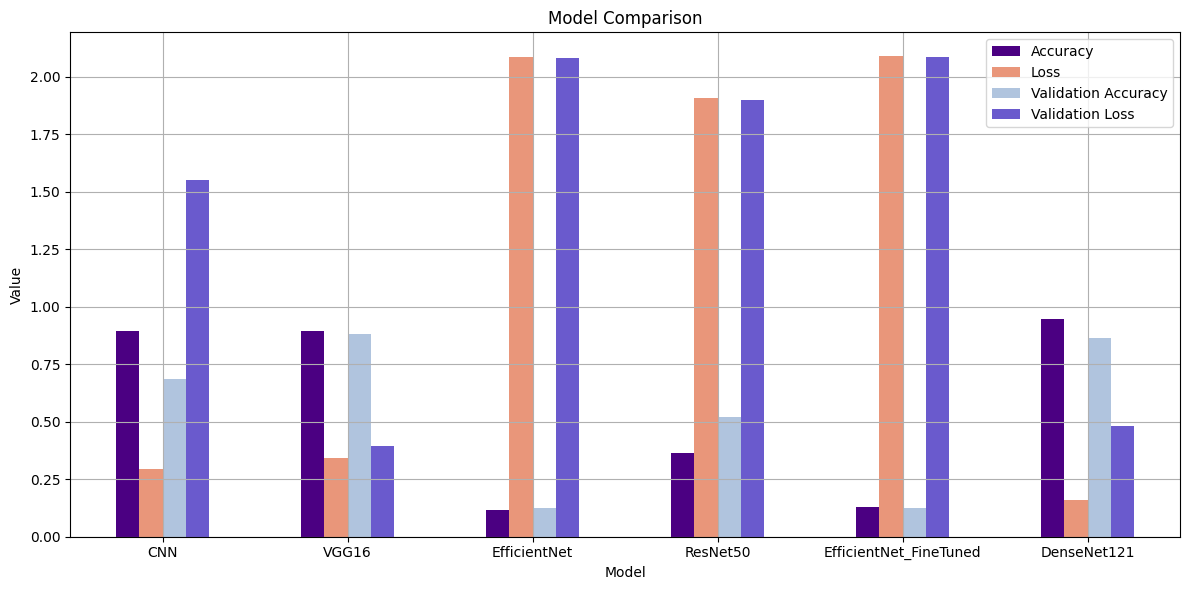

In [144]:
colors = ['indigo', 'darksalmon', 'lightsteelblue', 'slateblue']

df_comparison.set_index('Model')[['Accuracy', 'Loss', 'Validation Accuracy', 'Validation Loss']].plot(
    kind='bar',
    figsize=(12, 6),
    color=colors
)

plt.title("Model Comparison")
plt.ylabel("Value")
plt.xlabel("Model")
plt.xticks(rotation = 0)
plt.grid(True)
plt.tight_layout()
plt.show()

# **11. Prediction & Visualization Preparation**

In [148]:
pip install roifile

## 11.1. Prediction on Random Test Samples

In [157]:
from tensorflow.keras.preprocessing import image
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as patches
from PIL import Image
import os

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


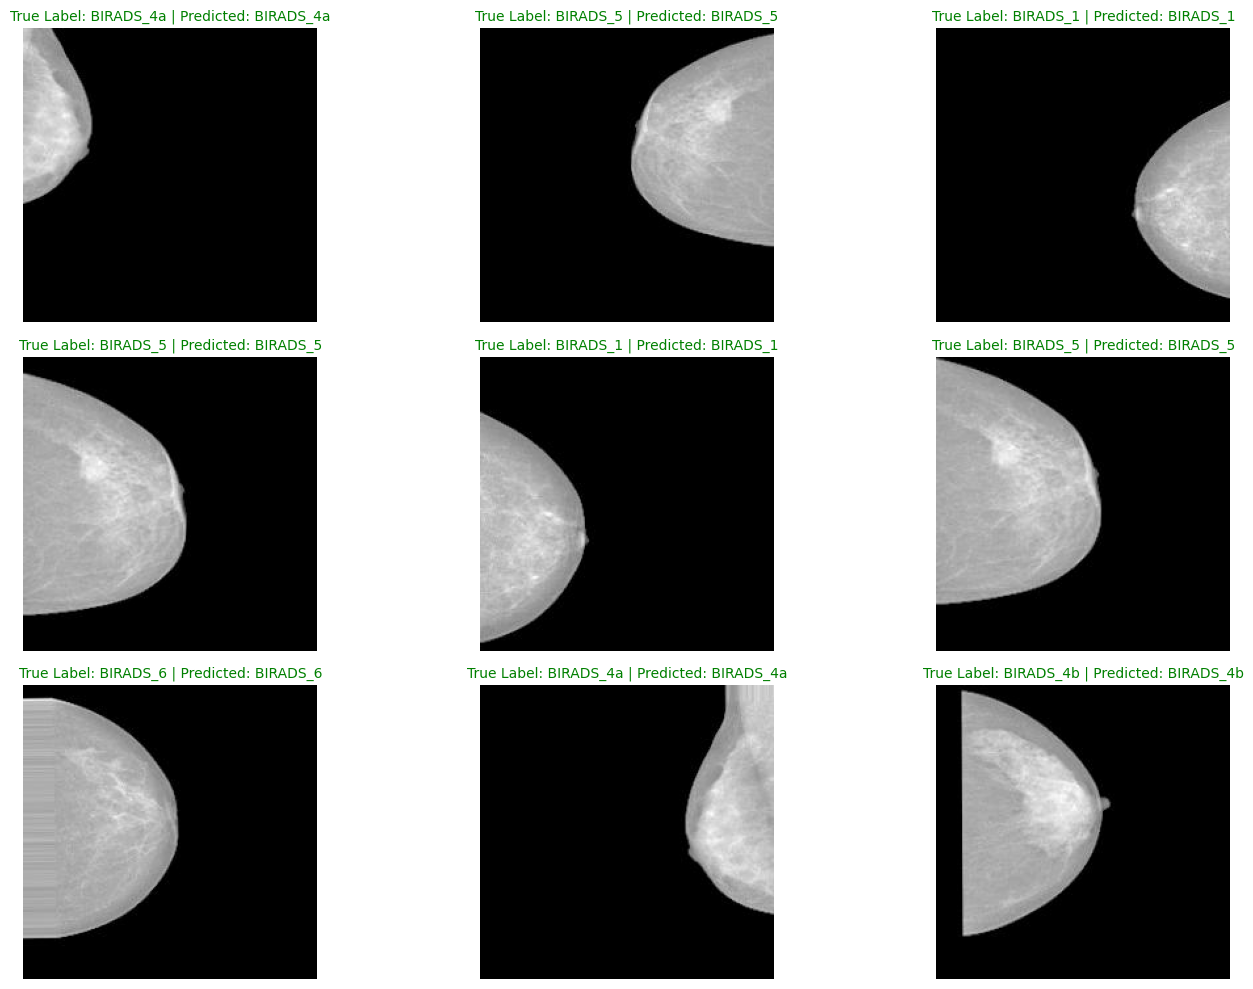

In [152]:
class_names = ["BIRADS_1", "BIRADS_2", "BIRADS_3", "BIRADS_4a",
               "BIRADS_4b", "BIRADS_4c", "BIRADS_5", "BIRADS_6"]

indices = random.sample(range(len(X_test)), 9)

plt.figure(figsize=(15, 10))

for i, idx in enumerate(indices):
    img_array = X_test[idx]
    true_label = class_names[np.argmax(y_test[idx])] if y_test.ndim == 2 else class_names[y_test[idx]]

    # Prediction
    prediction = model_densenet.predict(np.expand_dims(img_array, axis=0))
    predicted_label_index = np.argmax(prediction)
    predicted_label = class_names[predicted_label_index]

    # Visualization
    plt.subplot(3, 3, i + 1)
    plt.imshow(img_array)
    plt.axis("off")
    plt.title(f"True Label: {true_label} | Predicted: {predicted_label}",
          fontsize=10,
          color='green' if true_label == predicted_label else 'darkred')
plt.tight_layout()
plt.show()

## 11.2. Define Risk-Based BI-RADS Color Mapping

In [164]:
# BI-RADS label order and normalized colormap mapping
birads_order = ['1', '2', '3', '4a', '4b', '4c', '5', '6']
birads_normalized = {label: i / (len(birads_order)-1) for i, label in enumerate(birads_order)}
cmap = cm.get_cmap('RdYlGn_r')

def get_color_from_birads(label):
    if label not in birads_normalized:
        return "gray"
    return mcolors.to_hex(cmap(birads_normalized[label]))

def get_roi_color_by_truth(true_label=None, pred_label=None):
    if true_label is None:
        return "mediumpurple"
    if pred_label != true_label:
        return "black"
    return get_color_from_birads(true_label)

color_palette = {label: get_color_from_birads(label) for label in birads_order}
color_palette

{'1': '#006837',
 '2': '#39a758',
 '3': '#9dd569',
 '4a': '#e3f399',
 '4b': '#fee999',
 '4c': '#fca55d',
 '5': '#e34933',
 '6': '#a50026'}

## 11.3. Calculate ROI Area and Draw Polygon Overlays

In [165]:
# Function to calculate polygon area
def calculate_polygon_area(points):
    x = [p["x"] for p in points]
    y = [p["y"] for p in points]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

# ROI + Legend visualization
def draw_roi_with_palette(img_path, image_id, annotations, true_label=None, pred_label=None, save_dir=None):
    from matplotlib.patches import Rectangle

    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)
    rois = annotations.get(image_id, [])
    total_area = 0

    fig, (ax_img, ax_legend) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})
    ax_img.imshow(img_np)

    for roi in rois:
        points = roi["points"]
        if len(points) < 3:
            continue
        poly_coords = [(p["x"], p["y"]) for p in points]
        area = calculate_polygon_area(points)
        total_area += area

        color = get_roi_color_by_truth(true_label, pred_label)
        polygon = patches.Polygon(poly_coords, closed=True, edgecolor=color, facecolor=color, alpha=0.3, linewidth=2)
        ax_img.add_patch(polygon)

    title = f"True: {true_label or 'Unknown'}  Predicted: {pred_label or 'Unknown'}\nROI Area: {int(total_area)} pixels²"
    ax_img.set_title(title, fontsize=12)
    ax_img.axis("off")

    box_height = 0.6
    spacing = 0.15
    extra_items = 2
    full_height = (len(birads_order) + extra_items) * (box_height + spacing)
    ax_legend.set_xlim(0, 1)
    ax_legend.set_ylim(0, full_height)
    ax_legend.axis("off")

    for i, label in enumerate(birads_order):
        y = i * (box_height + spacing)
        color = get_color_from_birads(label)
        ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color=color))
        ax_legend.text(0.55, y + box_height / 2, f"BI-RADS {label}", va='center', ha='left', fontsize=10)

    y = len(birads_order) * (box_height + spacing)
    ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color="black"))
    ax_legend.text(0.55, y + box_height / 2, "Misestimation", va='center', ha='left', fontsize=10)

    y = (len(birads_order) + 1) * (box_height + spacing)
    ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color="mediumpurple"))
    ax_legend.text(0.55, y + box_height / 2, "Unknown", va='center', ha='left', fontsize=10)

    plt.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, image_id.replace(".jpg", "_with_palette.png"))
        plt.savefig(out_path)
        plt.close()
    else:
        plt.show()

## 11.4. Extract True Label for a Given Image

In [169]:
def extract_label(image_id):
    image_id = image_id.replace(".jpg", "")
    match = df_clean[df_clean['filename'].str.contains(image_id, case=False, na=False)]
    if not match.empty:
        label_value = str(match.iloc[0]['birads_label'])
        return label_value
    return "Unknown"

# **12. Final ROI Visualization with Model Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


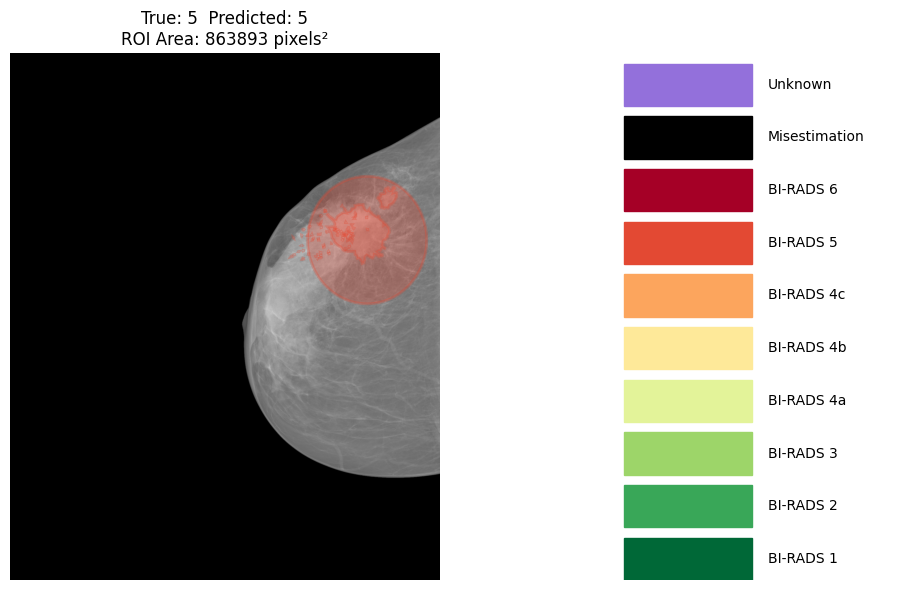

In [181]:
# Select a random test image with at least one valid polygon ROI
valid_ids_with_polygon = [k for k, v in annotations.items() if any(len(roi["points"]) >= 3 for roi in v)]
sample_id = random.choice(valid_ids_with_polygon)
img_path = f"/content/JPGs/{sample_id}"

# Load and preprocess image for prediction
img = Image.open(img_path).resize((224, 224)).convert("RGB")
img_array = np.array(img) / 255.0
input_img = np.expand_dims(img_array, axis=0)

# Predict with DenseNet121
prediction = model_densenet.predict(input_img)
pred_label_index = np.argmax(prediction)
pred_label = birads_order[pred_label_index]

# Get the true label from df_clean
true_label = extract_label(sample_id)

# Draw ROI and palette
draw_roi_with_palette(
    img_path = img_path,
    image_id = sample_id,
    annotations = annotations,
    true_label = true_label,
    pred_label = pred_label,
    save_dir = None
)